In [1]:
import json
import time

import flax.serialization
from luxai_s3.params import EnvParams
from luxai_s3.state import EnvState, serialize_env_actions, serialize_env_states
import jax
import jax.numpy as jnp

from luxai_s3.env import LuxAIS3Env

# from luxai_s3.wrappers import RecordEpisode

# Create the environment
env = LuxAIS3Env(auto_reset=False)
env_params = EnvParams(map_type=0, max_steps_in_match=50)

# Initialize a random key
key = jax.random.key(0)

# Reset the environment
key, reset_key = jax.random.split(key)
obs, state = env.reset(reset_key, params=env_params)
# Take a random action
key, subkey = jax.random.split(key)

env_params

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


EnvParams(max_steps_in_match=50, map_type=0, map_width=24, map_height=24, num_teams=2, match_count_per_episode=5, max_units=16, init_unit_energy=100, min_unit_energy=0, max_unit_energy=400, unit_move_cost=2, spawn_rate=5, unit_sap_cost=10, unit_sap_range=4, unit_sap_dropoff_factor=0.5, unit_energy_void_factor=0.125, max_energy_nodes=6, max_energy_per_tile=20, min_energy_per_tile=-20, max_relic_nodes=6, relic_config_size=5, fog_of_war=True, unit_sensor_range=2, nebula_tile_vision_reduction=1, nebula_tile_energy_reduction=0, nebula_tile_drift_speed=-0.05, energy_node_drift_speed=0.02, energy_node_drift_magnitude=5)

In [2]:
from argparse import Namespace
from dataclasses import dataclass
from typing import Any, Dict
import numpy as np
import networkx as nx
import numpy as np
from numpy.typing import ArrayLike, NDArray


def direction_to(src, target):
    ds = target - src
    dx = ds[0]
    dy = ds[1]
    if dx == 0 and dy == 0:
        return 0
    if abs(dx) > abs(dy):
        if dx > 0:
            return 2
        else:
            return 4
    else:
        if dy > 0:
            return 3
        else:
            return 1

In [3]:
def manhattan_distance(start_node: ArrayLike, end_node: ArrayLike) -> int:
    return abs(start_node[0] - end_node[0]) + abs(start_node[0] - end_node[0])

In [4]:
from jax import Array


def set_with_mask(previous_array: Array, new_array: Array, mask: Array):
    return previous_array.at[mask].set(new_array[mask])


mask = jnp.ones((10, 10), dtype=bool)
mask = mask.at[5, 5].set(False)
set_with_mask(jnp.zeros((10, 10)), jnp.ones((10, 10)), mask)

Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [5]:
from typing import Tuple
import jax
import jax.numpy as jnp
from jax.numpy import ndarray as Array


def init_distances_predecessors_visited(
    adjacency_matrix: Array, start_node: int
) -> Tuple[Array, Array, Array]:
    """
    Initialise les distances, les prédécesseurs et le tableau des nœuds visités.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence représentant les coûts des arêtes.
        start_node (int): L'indice du nœud de départ.

    Returns:
        Tuple[Array, Array, Array]: Les distances initialisées, les prédécesseurs et les nœuds visités.
    """
    num_nodes = adjacency_matrix.shape[0]
    distances = jnp.full((num_nodes,), jnp.inf)
    distances = distances.at[start_node].set(0)
    predecessors = jnp.full((num_nodes,), -1)  # -1 signifie "pas de prédécesseur"
    visited = jnp.zeros((num_nodes,), dtype=bool)
    return distances, predecessors, visited


def find_min_distance_unvisited_node(unvisited_nodes: Array, distances: Array) -> int:
    """
    Trouve le nœud non visité avec la plus petite distance.

    Parameters:
        unvisited_nodes (Array): Tableau booléen des nœuds non visités.
        distances (Array): Tableau des distances courantes des nœuds.

    Returns:
        int: Indice du nœud avec la plus petite distance non visité.
    """
    return jnp.argmin(jnp.where(unvisited_nodes, distances, jnp.inf))


def update_distances_and_predecessors(
    adjacency_matrix: Array,
    current_node: int,
    visited: Array,
    distances: Array,
    predecessors: Array,
) -> Tuple[Array, Array]:
    """
    Met à jour les distances et les prédécesseurs pour les voisins d'un nœud donné.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence des coûts.
        current_node (int): Nœud actuellement traité.
        visited (Array): Tableau booléen des nœuds visités.
        distances (Array): Distances minimales actuelles vers chaque nœud.
        predecessors (Array): Prédécesseurs de chaque nœud.

    Returns:
        Tuple[Array, Array]: Nouvelles distances et prédécesseurs mis à jour.
    """
    neighbors = adjacency_matrix[current_node]
    new_distances = jnp.where(
        ~visited, jnp.minimum(distances, distances[current_node] + neighbors), distances
    )
    new_predecessors = jnp.where(
        (new_distances < distances) & (~visited), current_node, predecessors
    )
    return new_distances, new_predecessors


def dijkstra_step(
    carry: Tuple[Array, Array, Array, Array], _: int
) -> Tuple[Tuple[Array, Array, Array, Array], None]:
    """
    Effectue une étape de l'algorithme de Dijkstra.

    Parameters:
        carry (Tuple[Array, Array, Array, Array]): Distances, prédécesseurs, nœuds visités et matrice d'adjacence.
        _ (int): Index de l'itération (inutile dans cette fonction).

    Returns:
        Tuple[Tuple[Array, Array, Array, Array], None]: État mis à jour.
    """
    distances, predecessors, visited, adjacency_matrix = carry
    current_node = find_min_distance_unvisited_node(~visited, distances)
    visited = visited.at[current_node].set(True)

    distances, predecessors = update_distances_and_predecessors(
        adjacency_matrix, current_node, visited, distances, predecessors
    )
    return (distances, predecessors, visited, adjacency_matrix), None


def dijkstra(adjacency_matrix: Array, start_node: int) -> Tuple[Array, Array, Array]:
    """
    Calcule les distances minimales depuis le nœud de départ vers tous les autres nœuds.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence représentant les coûts des arêtes.
        start_node (int): Nœud de départ.

    Returns:
        Tuple[Array, Array, Array]: Distances minimales, prédécesseurs et nœuds visités.
    """
    num_nodes = adjacency_matrix.shape[0]
    distances, predecessors, visited = init_distances_predecessors_visited(
        adjacency_matrix, start_node
    )

    (distances, predecessors, visited, _), _ = jax.lax.scan(
        dijkstra_step,
        (distances, predecessors, visited, adjacency_matrix),
        jnp.arange(num_nodes),
    )
    return distances, predecessors, visited


# Test unitaire
def test_dijkstra():
    graph = jnp.array(
        [[0, 1, jnp.inf, 3], [1, 0, 2, jnp.inf], [jnp.inf, 2, 0, 4], [3, jnp.inf, 4, 0]]
    )
    distances, predecessors, visited = dijkstra(adjacency_matrix=graph, start_node=0)
    expected_distances = jnp.array([0, 1, 3, 3])
    expected_predecessors = jnp.array([-1, 0, 1, 0])

    assert jnp.allclose(
        distances, expected_distances
    ), f"Distances incorrectes : {distances}"
    assert jnp.array_equal(
        predecessors, expected_predecessors
    ), f"Prédécesseurs incorrects : {predecessors}"
    print("Test réussi !")


# Exécuter le test
graph = jnp.array(
    [[0, 1, jnp.inf, 3], [1, 0, 2, jnp.inf], [jnp.inf, 2, 0, 4], [3, jnp.inf, 4, 0]]
)

graph = to_numpy_array(grid, nonedge=np.inf)
np.place(graph, graph == 0, np.inf)

distances, predecessors, visited = jax.jit(dijkstra)(
    adjacency_matrix=graph, start_node=0
)

NameError: name 'to_numpy_array' is not defined

In [6]:
def path(predecessors, end_node):
    prev_node = end_node
    path = [(prev_node // 10, prev_node % 10)]
    for _ in range(len(predecessors)):
        prev_node = predecessors[prev_node]
        if prev_node == -1:
            return list(reversed(path))
        path.append((prev_node // 10, prev_node % 10))


path(predecessors, 99)

NameError: name 'predecessors' is not defined

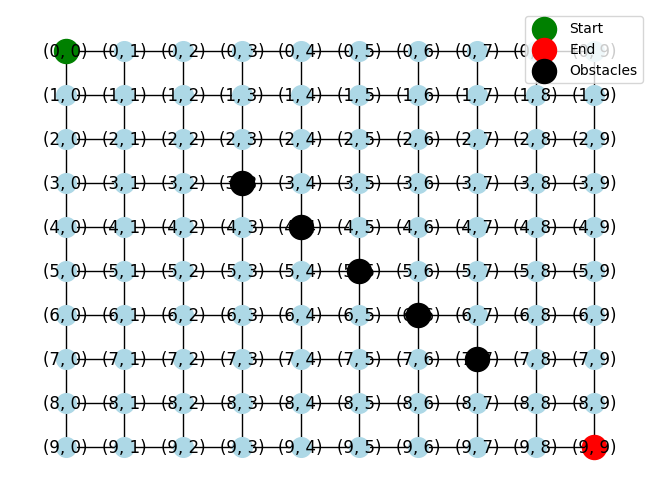

Chemin trouvé avec A* : [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (6, 5), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8), (9, 8), (9, 9)]
Chemin trouvé avec Dijkstra : [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Création d'un graphe en grille 10x10
n = 10
grid = nx.grid_2d_graph(n, n)

# Ajouter des obstacles (exemple de quelques nœuds bloqués)
obstacles = [(3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]

# Positions de départ et de fin
start, end = (0, 0), (9, 9)

# Dessiner le graphe
pos = {(x, y): (y, -x) for x, y in grid.nodes()}
nx.draw(grid, pos, with_labels=True, node_size=200, node_color="lightblue")
nx.draw_networkx_nodes(grid, pos, nodelist=[start], node_color="green", label="Start")
nx.draw_networkx_nodes(grid, pos, nodelist=[end], node_color="red", label="End")
nx.draw_networkx_nodes(
    grid, pos, nodelist=obstacles, node_color="black", label="Obstacles"
)
plt.legend()
plt.show()

# Calculer le chemin avec A* et Dijkstra
astar_path = nx.astar_path(
    grid,
    start,
    end,
    heuristic=lambda a, b: jnp.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2),
)
dijkstra_path = nx.dijkstra_path(grid, start, end)

print("Chemin trouvé avec A* :", astar_path)
print("Chemin trouvé avec Dijkstra :", dijkstra_path)

In [8]:
from networkx import to_numpy_array

to_numpy_array(grid)

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
from typing import Tuple
import jax
import jax.numpy as jnp
from jax.numpy import ndarray as Array


def init_distances_predecessors_visited(
    adjacency_matrix: Array, start_node: int
) -> Tuple[Array, Array, Array]:
    """
    Initialise les distances, les prédécesseurs et le tableau des nœuds visités.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence représentant les coûts des arêtes.
        start_node (int): L'indice du nœud de départ.

    Returns:
        Tuple[Array, Array, Array]: Les distances initialisées, les prédécesseurs et les nœuds visités.
    """
    num_nodes = adjacency_matrix.shape[0]
    distances = jnp.full((num_nodes,), jnp.inf)
    distances = distances.at[start_node].set(0)
    predecessors = jnp.full((num_nodes,), -1)  # -1 signifie "pas de prédécesseur"
    visited = jnp.zeros((num_nodes,), dtype=bool)
    return distances, predecessors, visited


def find_min_distance_unvisited_node(unvisited_nodes: Array, distances: Array) -> int:
    """
    Trouve le nœud non visité avec la plus petite distance.

    Parameters:
        unvisited_nodes (Array): Tableau booléen des nœuds non visités.
        distances (Array): Tableau des distances courantes des nœuds.

    Returns:
        int: Indice du nœud avec la plus petite distance non visité.
    """
    return jnp.argmin(jnp.where(unvisited_nodes, distances, jnp.inf))


def update_distances_and_predecessors(
    adjacency_matrix: Array,
    current_node: int,
    visited: Array,
    distances: Array,
    predecessors: Array,
    end_node: int,
) -> Tuple[Array, Array]:
    """
    Met à jour les distances et les prédécesseurs pour les voisins d'un nœud donné.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence des coûts.
        current_node (int): Nœud actuellement traité.
        visited (Array): Tableau booléen des nœuds visités.
        distances (Array): Distances minimales actuelles vers chaque nœud.
        predecessors (Array): Prédécesseurs de chaque nœud.

    Returns:
        Tuple[Array, Array]: Nouvelles distances et prédécesseurs mis à jour.
    """
    neighbors = adjacency_matrix[current_node]

    new_distances = jnp.where(
        ~visited,
        jnp.minimum(
            distances,
            distances[current_node] + neighbors + euclidean_distance_on_square(current_node, end_node),
        ),
        distances,
    )
    new_predecessors = jnp.where(
        (new_distances < distances) & (~visited), current_node, predecessors
    )
    return new_distances, new_predecessors


def astar_step(
    carry: Tuple[Array, Array, Array, Array]
) -> Tuple[Tuple[Array, Array, Array, Array], None]:
    """
    Effectue une étape de l'algorithme de Dijkstra.

    Parameters:
        carry (Tuple[Array, Array, Array, Array]): Distances, prédécesseurs, nœuds visités et matrice d'adjacence.
        _ (int): Index de l'itération (inutile dans cette fonction).

    Returns:
        Tuple[Tuple[Array, Array, Array, Array], None]: État mis à jour.
    """
    distances, predecessors, visited, adjacency_matrix, end_node = carry
    current_node = find_min_distance_unvisited_node(~visited, distances)
    visited = visited.at[current_node].set(True)

    distances, predecessors = update_distances_and_predecessors(
        adjacency_matrix,
        current_node,
        visited,
        distances,
        predecessors,
        end_node,
    )
    return (
        distances,
        predecessors,
        visited,
        adjacency_matrix,
        end_node,
    )

def is_not_in_visited(carry: Tuple[Array, Array, Array, Array]) -> bool:
    """
    Vérifie si tous les nœuds ont été visités.

    Parameters:
        carry (Tuple[Array, Array, Array, Array]): Distances, prédécesseurs, nœuds visités et matrice d'adjacence.

    Returns:
        bool: Vrai si tous les nœuds ont été visités, faux sinon.
    """
    _, _, visited, _, end_node = carry
    jax.debug.print("{x} {y}", x=visited[end_node], y=visited)
    return visited[end_node] == False

def astar(
    adjacency_matrix: Array, start_node: int, end_node: int
) -> Tuple[Array, Array, Array]:
    """
    Calcule les distances minimales depuis le nœud de départ vers tous les autres nœuds.

    Parameters:
        adjacency_matrix (Array): Matrice d'adjacence représentant les coûts des arêtes.
        start_node (int): Nœud de départ.

    Returns:
        Tuple[Array, Array, Array]: Distances minimales, prédécesseurs et nœuds visités.
    """
    num_nodes = adjacency_matrix.shape[0]
    distances, predecessors, visited = init_distances_predecessors_visited(
        adjacency_matrix, start_node
    )

    distances, predecessors, visited, _, _ = jax.lax.while_loop(
        is_not_in_visited,
        astar_step,
        (
            distances,
            predecessors,
            visited,
            adjacency_matrix,
            end_node,
        ),
    )
    return distances, predecessors, visited


# Test unitaire
def test_astar():
    graph = jnp.array(
        [[0, 1, jnp.inf, 3], [1, 0, 2, jnp.inf], [jnp.inf, 2, 0, 4], [3, jnp.inf, 4, 0]]
    )
    distances, predecessors, visited = astar(
        adjacency_matrix=graph, start_node=0, end_node=3, heuristic=lambda x, y: 0
    )
    expected_distances = jnp.array([0, 1, 3, 3])
    expected_predecessors = jnp.array([-1, 0, 1, 0])

    assert jnp.allclose(
        distances, expected_distances
    ), f"Distances incorrectes : {distances}"
    assert jnp.array_equal(
        predecessors, expected_predecessors
    ), f"Prédécesseurs incorrects : {predecessors}"
    print("Test réussi !")


# Exécuter le test
graph = jnp.array(
    [[0, 1, jnp.inf, 3], [1, 0, 2, jnp.inf], [jnp.inf, 2, 0, 4], [3, jnp.inf, 4, 0]]
)

def manhattan_distance_on_square(start_node: ArrayLike, end_node: ArrayLike) -> int:
    start_node_row = start_node // 10
    start_node_col = start_node % 10
    end_node_row = end_node // 10
    end_node_col = end_node % 10
    return jnp.abs(start_node_row - end_node_row) + jnp.abs(start_node_col - end_node_col)

def euclidean_distance_on_square(start_node: ArrayLike, end_node: ArrayLike) -> int:
    start_node_row = start_node // 10
    start_node_col = start_node % 10
    end_node_row = end_node // 10
    end_node_col = end_node % 10
    return jnp.sqrt((start_node_row - end_node_row) ** 2 + (start_node_col - end_node_col) ** 2)

graph = to_numpy_array(grid, nonedge=np.inf)
np.place(graph, graph == 0, np.inf)

d, predecessors, _ = astar(adjacency_matrix=graph, start_node=0, end_node=99)

False [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[inf  1. inf inf inf inf inf inf inf inf  1. inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf in

[ 1. inf  1. inf inf inf inf inf inf inf inf  1. inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf] 12.041594505310059 13.727922439575195
False [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False F

In [27]:
path(predecessors, 99)

[(Array(0, dtype=int32), Array(0, dtype=int32)),
 (Array(0, dtype=int32), Array(1, dtype=int32)),
 (Array(1, dtype=int32), Array(1, dtype=int32)),
 (Array(1, dtype=int32), Array(2, dtype=int32)),
 (Array(2, dtype=int32), Array(2, dtype=int32)),
 (Array(2, dtype=int32), Array(3, dtype=int32)),
 (Array(3, dtype=int32), Array(3, dtype=int32)),
 (Array(3, dtype=int32), Array(4, dtype=int32)),
 (Array(4, dtype=int32), Array(4, dtype=int32)),
 (Array(4, dtype=int32), Array(5, dtype=int32)),
 (Array(5, dtype=int32), Array(5, dtype=int32)),
 (Array(5, dtype=int32), Array(6, dtype=int32)),
 (Array(6, dtype=int32), Array(6, dtype=int32)),
 (Array(6, dtype=int32), Array(7, dtype=int32)),
 (Array(7, dtype=int32), Array(7, dtype=int32)),
 (Array(7, dtype=int32), Array(8, dtype=int32)),
 (Array(8, dtype=int32), Array(8, dtype=int32)),
 (Array(8, dtype=int32), Array(9, dtype=int32)),
 (9, 9)]

In [31]:
d

Array([  0.      ,  13.727922,  26.769516,  39.171272,  50.987926,
        62.283558,  73.132416,  83.61925 ,  93.83879 , 103.89418 ,
        13.727922,  26.769516,  39.083225,  50.71337 ,  61.71337 ,
        72.147354,  82.09163 ,  91.635635, 100.88184 , 109.9441  ,
        26.769516,  39.083225,  50.71337 ,  61.612865,  71.83241 ,
        81.43474 ,  90.496994,  99.11277 , 107.39288 , 115.46395 ,
        39.171272,  50.71337 ,  61.612865,  71.83241 ,  81.317696,
        90.127945,  98.33905 , 106.04726 , 113.37181 , 120.454575,
        50.987926,  61.71337 ,  71.83241 ,  81.317696,  90.127945,
        98.19901 , 105.602135, 112.43309 , 118.81825 , 124.917274,
        62.283558,  72.147354,  81.43474 ,  90.127945,  98.19901 ,
       105.602135, 112.25899 , 118.25899 , 123.731125, 128.85423 ,
        73.132416,  82.09163 ,  90.496994,  98.33905 , 105.602135,
       112.25899 , 118.25899 , 123.501625, 128.10718 , 132.26945 ,
        83.61925 ,  91.635635,  99.11277 , 106.04726 , 112.433

In [13]:
def update_nodes_from_obs(G: nx.DiGraph, obs: Dict[str, Any]):
    visible_tiles_indices = jax.numpy.indices(obs["sensor_mask"].shape)[
        :, obs["sensor_mask"]
    ]
    visible_energies = obs["map_features"]["energy"][obs["sensor_mask"]]
    visible_type_tiles = obs["map_features"]["tile_type"][obs["sensor_mask"]]
    for i in range(visible_tiles_indices.shape[1]):
        node_location = tuple(visible_tiles_indices[:, i].tolist())
        symmetric_node_location = tuple(np.array([23, 23]) - np.array(node_location))
        cost = visible_energies[i]
        G.add_node(node_location, energy=cost, type=visible_type_tiles[i])
        G.add_node(symmetric_node_location, energy=cost, type=visible_type_tiles[i])

    not_visible_tiles_indices = jax.numpy.indices(obs["sensor_mask"].shape)[
        :, ~obs["sensor_mask"]
    ]

    for i in range(not_visible_tiles_indices.shape[1]):
        node_location = tuple(not_visible_tiles_indices[:, i].tolist())
        G.add_node(node_location, energy=0, type=-1)


update_nodes_from_obs(G.map, obs_to_dict(obs_player_0))

NameError: name 'G' is not defined

In [57]:
G.map.nodes.data()

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': 0, 'type': -1}, (1, 1): {'energy': 0, 'type': -1}, (1, 2): {'energy': 0, 'type': -1}, (1, 3): {'energy': 0, 'type

In [58]:
from networkx import neighbors


def remove_edges_from_asteroides(G: nx.DiGraph):
    neighbors_to_remove = []
    for n in G.nodes:
        if G.nodes[n].get("type", 0) == 2:
            for neighbor in G.neighbors(n):
                neighbors_to_remove.append((n, neighbor))

    G.remove_edges_from(neighbors_to_remove)


remove_edges_from_asteroides(G.map)

G.map.nodes.data()

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': 0, 'type': -1}, (1, 1): {'energy': 0, 'type': -1}, (1, 2): {'energy': 0, 'type': -1}, (1, 3): {'energy': 0, 'type

In [59]:
def update_edges_cost_from_energy_nodes(G: nx.DiGraph):
    for node_in, node_out in G.edges:
        # Get energy values of the two nodes
        energy_node_in = G.nodes[node_in].get("energy", 0)
        energy_node_out = G.nodes[node_out].get("energy", 0)

        # Calculate edge cost as |energy_u - energy_v| + 1000
        cost = energy_node_in - energy_node_out + 1000
        G.edges[node_in, node_out]["cost"] = cost


update_edges_cost_from_energy_nodes(G.map)

In [60]:
def get_closest_path(
    G: nx.DiGraph, start_node: ArrayLike, end_node: ArrayLike
) -> ArrayLike:
    return nx.astar_path(
        G, start_node, end_node, heuristic=manhattan_distance, weight="cost"
    )


list_nodes = get_closest_path(G.map, (0, 0), (16, 16))
direction_to(jnp.array(list_nodes[0]), jnp.array(list_nodes[1]))

2

In [103]:
class Agent:
    def __init__(self, player: str, env_cfg: Dict[str, Any]) -> None:
        np.random.seed(0)

        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        self.env_cfg = env_cfg

        self.graph = Graph(env_cfg["map_width"], env_cfg["map_height"])

        self.unit_explore_locations = dict()

    def act(self, step: int, obs: Dict[str, Any], remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit.

        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        update_nodes_from_obs(self.graph.map, obs)
        remove_edges_from_asteroides(self.graph.map)
        update_edges_cost_from_energy_nodes(self.graph.map)

        unit_mask = np.array(obs["units_mask"][self.team_id])
        unit_positions = np.array(
            obs["units"]["position"][self.team_id]
        )  # shape (max_units, 2)
        available_unit_ids = np.where(unit_mask)[0]

        # Act randomly
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)

        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]

            if (
                unit_id not in self.unit_explore_locations
                or np.sum(unit_pos - self.unit_explore_locations[unit_id]) == 0
            ):
                self.unit_explore_locations[unit_id] = (
                    np.random.randint(0, self.env_cfg["map_width"]),
                    np.random.randint(0, self.env_cfg["map_height"]),
                )

            print(self.player, f" unit {unit_id}")
            print(tuple(unit_pos), self.unit_explore_locations[unit_id])
            list_nodes = get_closest_path(
                G.map, tuple(unit_pos), self.unit_explore_locations[unit_id]
            )

            actions[unit_id] = [
                direction_to(jnp.array(list_nodes[0]), jnp.array(list_nodes[1])),
                0,
                0,
            ]
        return actions

In [125]:
from luxai_s3.state import EnvObs


def env_params_to_dict(env_params: EnvParams) -> Dict[str, Any]:
    return {
        "map_width": env_params.map_width,
        "map_height": env_params.map_height,
        "max_steps_in_match": env_params.max_steps_in_match,
        "max_units": env_params.max_units,
    }


def obs_to_dict(obs: EnvObs) -> Dict[str, Any]:
    return {
        "units": {
            "position": obs.units.position,
            "energy": obs.units.energy,
        },
        "units_mask": obs.units_mask,
        "sensor_mask": obs.sensor_mask,
        "map_features": {
            "energy": obs.map_features.energy,
            "tile_type": obs.map_features.tile_type,
        },
        "relic_nodes": obs.relic_nodes,
        "relic_nodes_mask": obs.relic_nodes_mask,
        "team_points": obs.team_points,
        "team_wins": obs.team_wins,
        "steps": obs.steps,
        "match_steps": obs.match_steps,
    }

In [126]:
from typing import OrderedDict


agent_0 = Agent("player_0", env_params_to_dict(env_params))
agent_1 = Agent("player_1", env_params_to_dict(env_params))

for _ in range(19):
    key, subkey = jax.random.split(key)
    action = OrderedDict(
        {
            "player_0": agent_0.act(0, obs_to_dict(obs["player_0"])),
            "player_1": agent_1.act(0, obs_to_dict(obs["player_1"])),
        }
    )
    obs, state, reward, terminated, truncated, info = env.step(
        subkey, state, action, params=env_params
    )

player_0  unit 0
(np.int16(12), np.int16(5)) (12, 15)
player_0  unit 1
(np.int16(4), np.int16(0)) (21, 0)
player_0  unit 2
(np.int16(4), np.int16(0)) (3, 3)
player_0  unit 3
(np.int16(4), np.int16(0)) (7, 9)
player_0  unit 4
(np.int16(4), np.int16(0)) (19, 21)
player_1  unit 0
(np.int16(7), np.int16(23)) (18, 4)
player_1  unit 1
(np.int16(19), np.int16(23)) (23, 6)
player_1  unit 2
(np.int16(22), np.int16(23)) (12, 1)
player_1  unit 3
(np.int16(22), np.int16(23)) (6, 7)
player_1  unit 4
(np.int16(23), np.int16(19)) (23, 14)
player_0  unit 0
(np.int16(12), np.int16(5)) (12, 15)
player_0  unit 1
(np.int16(4), np.int16(0)) (21, 0)
player_0  unit 2
(np.int16(3), np.int16(0)) (3, 3)
player_0  unit 3
(np.int16(4), np.int16(0)) (7, 9)
player_0  unit 4
(np.int16(4), np.int16(0)) (19, 21)
player_0  unit 5
(np.int16(0), np.int16(0)) (17, 5)
player_1  unit 0
(np.int16(8), np.int16(23)) (18, 4)
player_1  unit 1
(np.int16(19), np.int16(23)) (23, 6)
player_1  unit 2
(np.int16(22), np.int16(23)) (12,

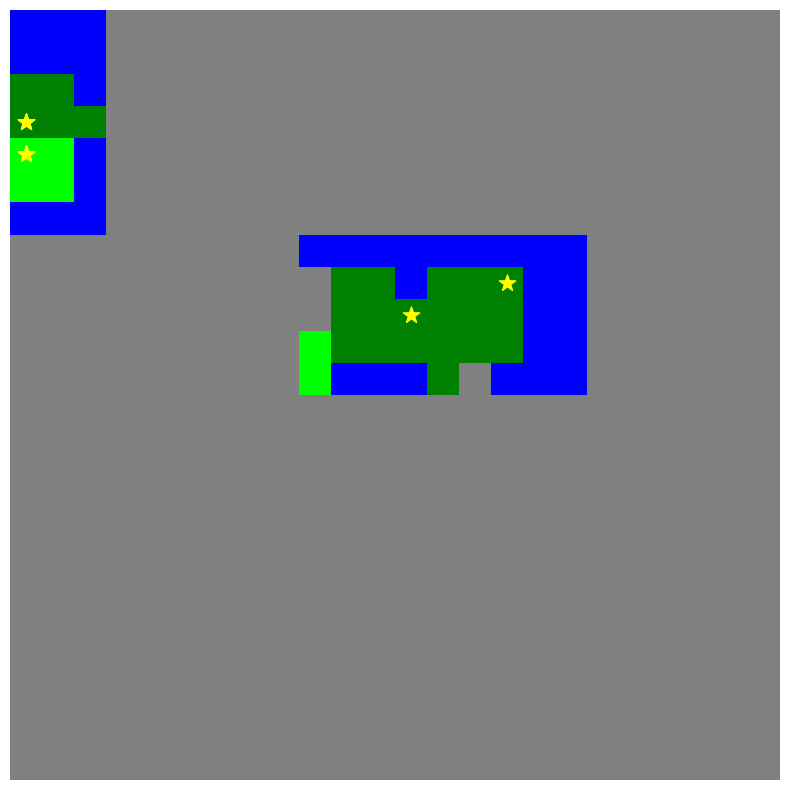

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Créer une matrice vide
matrix = np.empty((24, 24), dtype=object)

# Remplir la matrice avec les types des cases
for (x, y), data in agent_0.graph.map.nodes(data=True):
    matrix[x, y] = data["type"]

# Conversion en DataFrame pour un affichage facile
df_map = pd.DataFrame(matrix)

# Définition des couleurs pour chaque type de case
color_map = {
    -1: (128, 128, 128),  # grey
    0: (0, 0, 255),  # blue
    1: (0, 128, 0),  # green
    2: (0, 255, 0),  # light green
}

# Convertir la matrice de types en une matrice RGB
color_matrix_rgb = np.array(
    [[color_map[int(val)] for val in row] for row in df_map.values], dtype=np.int32
)

# Afficher la carte
plt.figure(figsize=(10, 10))
plt.imshow(color_matrix_rgb)
plt.axis("off")

# Ajouter des étoiles aux positions de type 3
for x, y in (
    obs["player_0"]
    .units.position[0][obs["player_0"].units.position[0] != -1]
    .reshape(-1, 2)
):
    if (x, y) != (-1, -1):
        plt.scatter(
            y, x, color="yellow", marker="*", s=150
        )  # jaune avec un marqueur étoile

plt.show()